In [2]:
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from scipy import stats
# from datetime import timedelta
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%pylab inline
plt.style.use('seaborn')
% matplotlib inline
display(HTML("<style>.container { width:95% !important; }</style>"))
plt.rcParams['figure.figsize'] = [15, 9]
matplotlib.rc('xtick', labelsize=18)
matplotlib.rc('ytick', labelsize=18)
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000



from datetime import datetime
from datetime import timedelta

from sqlalchemy import create_engine
import pymysql



Populating the interactive namespace from numpy and matplotlib


Questions
 Basically we are making an assumption based on past realized is an indicator of future realized.
 Would the future tick in the open should be weighted the same vs the future tick during the day?
 If there is a very big tick (outlier) how much impact should that have for realized during the future.
 When the future goes limit up/down and doesn&#39;t move, should that be an indicator of the past
realized?
 What lamda and sampling time we should use? --> take it as fixed. use the one in the script


look into different expiries/ how fast future realizes

# ETL

 - what's the value ? vol * 100? 
 - what's the 'field' value? 
 


In [26]:
## the code neal sent me

engine = create_engine(
           "mysql+pymysql://{}:{}@{}/{}?charset=utf8mb4".format("data",
                                                                "data",
                                                                "#############",
                                                                "staging"))
df = pd.read_sql_query(
           '''select *
           from future
            where product='HE' 
            and TIME(created_date) > '08:30:00' 
            and TIME(created_date) < '13:05:00'  
            and created_date > DATE_SUB(NOW(), INTERVAL 3 MONTH)
            and expiry = 'MAY19'
            order by created_date desc''',
           con=engine)

## latest 2 week data

In [30]:
param = pd.read_sql_query('''SELECT * 
    FROM staging.param 
    where product = 'XCME.HE' 
    and field = 'PE25'   
    and created_date > DATE_SUB(NOW(), INTERVAL 3 MONTH) 
    and expiry = 'MAY19'
    order by created_date desc ''',con=engine)

## implied volatility, can it be applied same time range ? 

,id,product,expiry,field,column_name,value,created_date
0,4124106,XCME.HE,MAY19,PE25,0.5,27.1379,2019-04-25 21:08:54
1,4124015,XCME.HE,MAY19,PE25,0.5,27.1379,2019-04-25 21:08:35
2,4123152,XCME.HE,MAY19,PE25,0.5,27.1379,2019-04-25 20:46:27
3,4123131,XCME.HE,MAY19,PE25,0.5,27.1379,2019-04-25 20:46:26
4,4123040,XCME.HE,MAY19,PE25,0.5,27.1379,2019-04-25 20:44:11


In [54]:
pd.read_sql_query('''SELECT  created_date AT TIME ZONE 'Central America Standard Time' AS created_date_cdt
FROM staging.param limit 100''',con = engine)
#pd.read_sql_query('''SET GLOBAL time_zone ='Central America Standard Time'  ''',con = engine)


ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (2, 77))



ProgrammingError: (pymysql.err.ProgrammingError) (1064, u"You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near 'TIME ZONE 'Central America Standard Time' AS created_date_cdt\nFROM staging.param' at line 1") [SQL: "SELECT  created_date AT TIME ZONE 'Central America Standard Time' AS created_date_cdt\nFROM staging.param limit 100"]

In [31]:
sampling_period = '3T' # from michael's script
# for ewma I'm going to use the half life function I made 




df.created_date = pd.to_datetime(df.created_date)

total_timerange = 5 

expiries = []
for i in range(len(df.expiry.unique())):
    exp = pd.DataFrame()
    exp_str = df.expiry.unique()[i]
    exp = df[df.expiry == exp_str].groupby(df[df.expiry == exp_str ].created_date.dt.floor(sampling_period)).tail(n=1)
    exp = exp.reset_index()
    exp['index'] = exp.index
    exp = exp.set_index('created_date')
    exp = exp.sort_index()
    exp['log_ret'] = np.log(exp.price) - np.log(exp.price.shift(1))
    exp['log_ret_sqr'] = np.power(exp['log_ret'],2)
    
    print 'total time range of the data frame is : {}'.format(exp.index.max()-exp.index.min())
    ## gotta fix the date row count function slightly and update! 
    #exp = exp.sort_index(ascending = False) # because the most recent has to be on the first row for ewma calculation
    ## I'm going to just use the length of the df for ewma application. This has to updated later
    #as the ewma should be optimized
    #ewma_lambda = half_weight_lambda(dates_rows_count(exp, 5)) ## Here index means the iteration number. Don't be confused
    print "At this level, ewma lambda will be calculated as the 5 days"
    #exp['weight'] = (1-ewma_lambda)*np.power(ewma_lambda,exp['index'])
    #exp['weighted_log_ret_sqr'] = exp['weight'] * exp['log_ret_sqr']
    
    expiries.append(exp)
    
apr19 = expiries[0]


total time range of the data frame is : 87 days 04:33:39
At this level, ewma lambda will be calculated as the 5 days


annualized volaitlity of the whole df time range


0.3107501632283545

rolling stuff


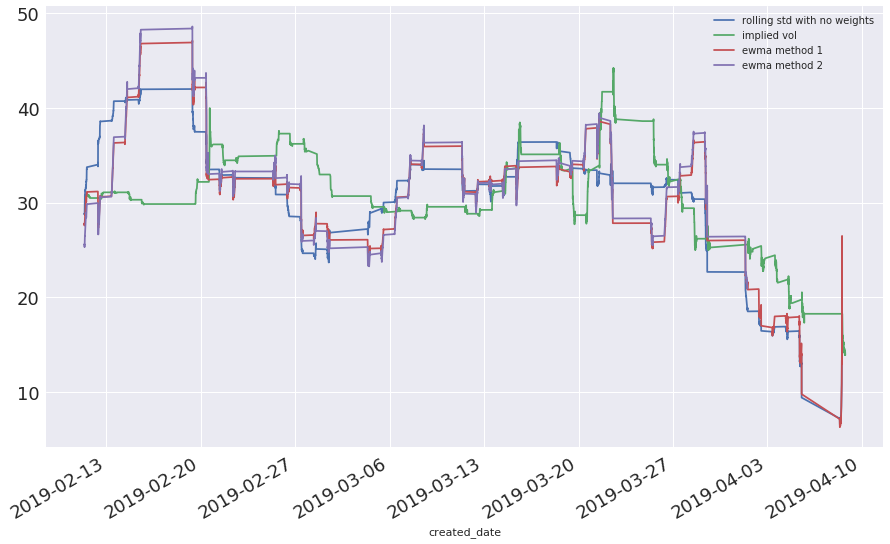

In [290]:
#apr19.head(-1)
## my understanding of ewma was the t = 0 return doesn't exist. <-- gotta check on the calculation. 
## This is the cause of the calculation mis match

## Also why is the tail of the rolling vol ann missin?
#apr19.ewma_vol_ann.plot()
print "annualized volaitlity of the whole df time range"
(np.sqrt(apr19[filt].log_ret_sqr.sum()/len(apr19[filt]))* np.sqrt(252 * 4.2 * 20))
print  "rolling stuff"
(apr19[filt].log_ret.rolling(dates_rows_count(apr19,7), min_periods = 10).std()* np.sqrt(252 * 4.2 * 20)*100).plot()
apr19_vol.value.plot()
apr19[filt].ewma_vol_ann.plot()
apr19[filt].rolling_vol_ann.plot()
plt.legend(['rolling std with no weights','implied vol','ewma method 1','ewma method 2'])

In [ ]:
# take out the weekend from the x-axis

In [6]:
param.expiry.unique()

array([u'APR19'], dtype=object)

In [32]:



param.created_date = pd.to_datetime(param.created_date)

 
expiries = []

for i in range(len(param.expiry.unique())):
    exp = pd.DataFrame()
    exp_str = param.expiry.unique()[i]
    exp = param[param.expiry == exp_str].groupby(param[param.expiry == exp_str ].created_date.dt.floor(sampling_period)).tail(n=1)
    exp = exp.reset_index()
    exp['index'] = exp.index
    exp = exp.set_index('created_date')
    exp = exp.sort_index()
    expiries.append(exp)

apr19_vol = expiries[0]

What I have the price of the future. so my theoritical volatility should be compared against actual. 
1. my ewma calculation method is the sum of weighted log ret sqr, thus since the lag I'm using the whole time range, I can only get one number, which can't be backtested/ or how long should the weight be ? also should I calculate this at a rolling base?
2. what would the actual be? the return of next 3 minute? this is tied to the first point of the Questions
3. the database data starting from january 14--> is this enough to backtest?  
4. ewma_realized_vol =np.sqrt(df_copy['return_per_second_squared*weight'].sum()/df_copy['weight'].sum()) * np.sqrt(252 * 4.2 * 20) -->Is this the right calculation in terms of a) division, and b) how did 4.2 and 20 come about? -->4.2 comes from the number of hours being traded per day and 20 is the number of 3 minutes contained in an hour. 


compare it to the implied volatility you get from the price of option. explore sql. 

# Actual Work

/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


<Figure size 1080x648 with 0 Axes>

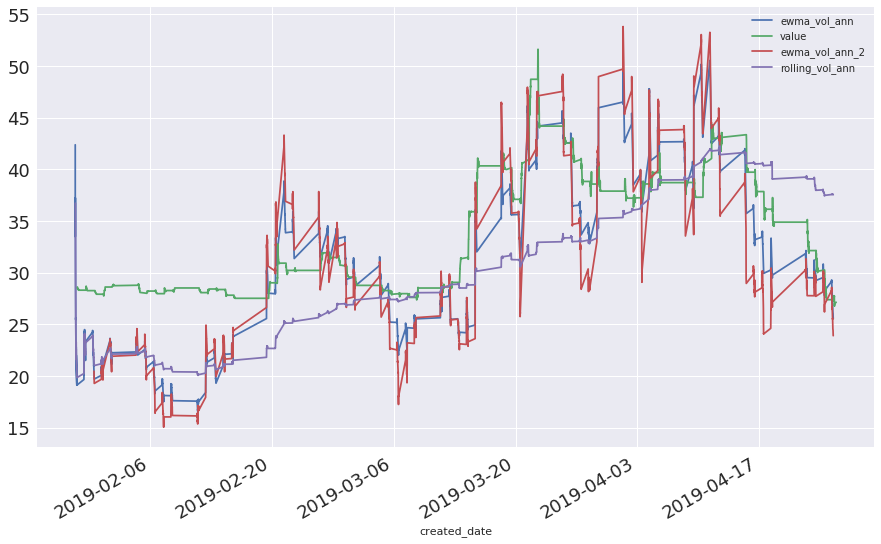

<Figure size 1080x648 with 0 Axes>

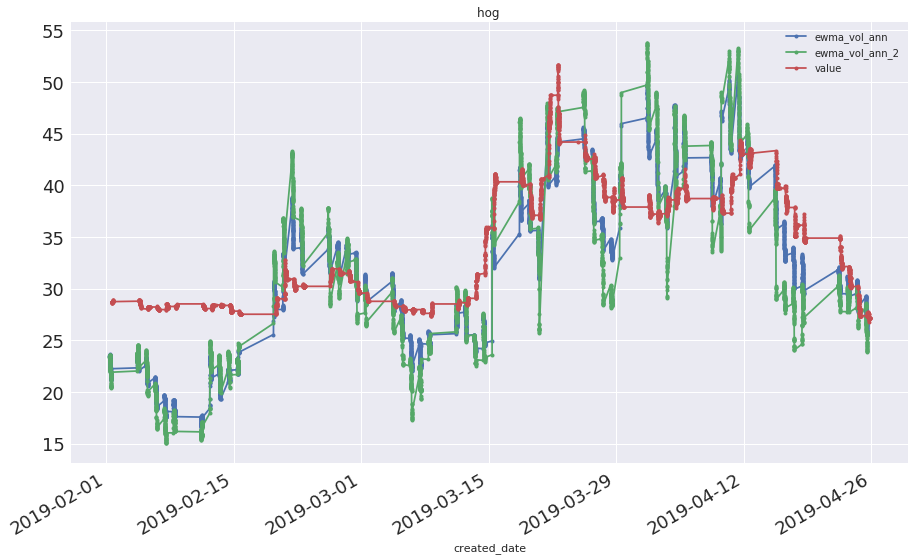

In [33]:
from functools import partial
## we are only looking into apr19 

## Going to use pd.DataFrame.ewma for optimization iteration

a = (np.sqrt(apr19['log_ret_sqr'].ewm(alpha = 0.005).mean()) * np.sqrt(252 * 4.2 * 20) * 100 )
apr19['ewma_vol_ann'] = a
apr19['ewma_vol_ann'].plot()
apr19_vol.value.plot()

window = dates_rows_count(apr19,3)
alpha = 0.005    # This is ewma's decay factor. Which I really don't understand
weights = list(reversed([(1-alpha)**n for n in range(window)]))
ewma = partial(average, weights=weights)
rolling_average = np.sqrt(apr19['log_ret_sqr'].rolling(window).apply(ewma))* np.sqrt(252 * 4.2 * 20) * 100
apr19['ewma_vol_ann_2'] = rolling_average
apr19['ewma_vol_ann_2'].plot()


rolling_no_weight = (apr19.log_ret.rolling(dates_rows_count(apr19,30), min_periods = 10).std()* np.sqrt(252 * 4.2 * 20)*100)
apr19['rolling_vol_ann'] = rolling_no_weight
apr19['rolling_vol_ann'].plot()
plt.legend()
plt.figure()
apr19[apr19.index.date >= datetime.date(2019,2,1)][['ewma_vol_ann','ewma_vol_ann_2']].plot(style = 'o-',ms = 4)
apr19_vol[apr19_vol.index.date>= datetime.date(2019,2,1)].value.plot(title = 'hog ',style = 'o-',ms = 4)
plt.legend()

## opening analysis

<Figure size 1080x648 with 0 Axes>

<Figure size 1080x648 with 0 Axes>

<Figure size 1080x648 with 0 Axes>

<Figure size 1080x648 with 0 Axes>

<Figure size 1080x648 with 0 Axes>

<Figure size 1080x648 with 0 Axes>

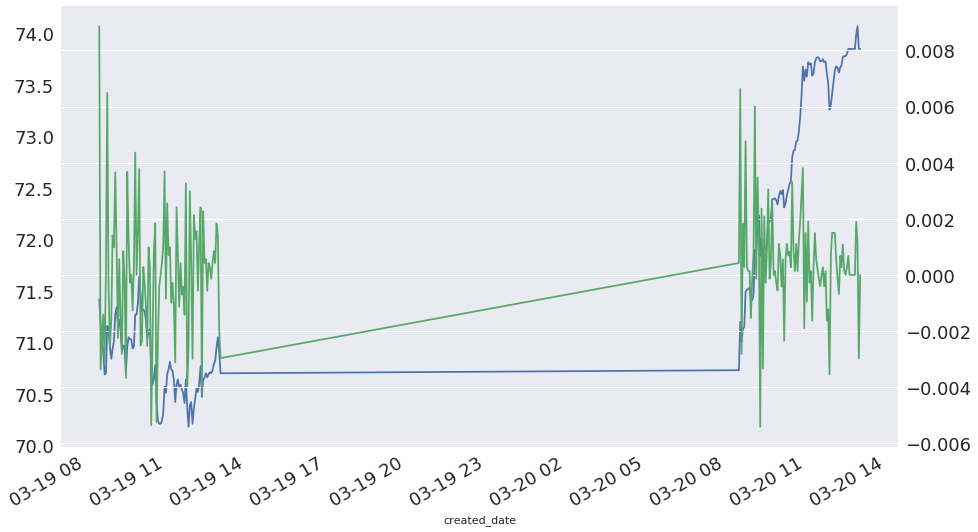

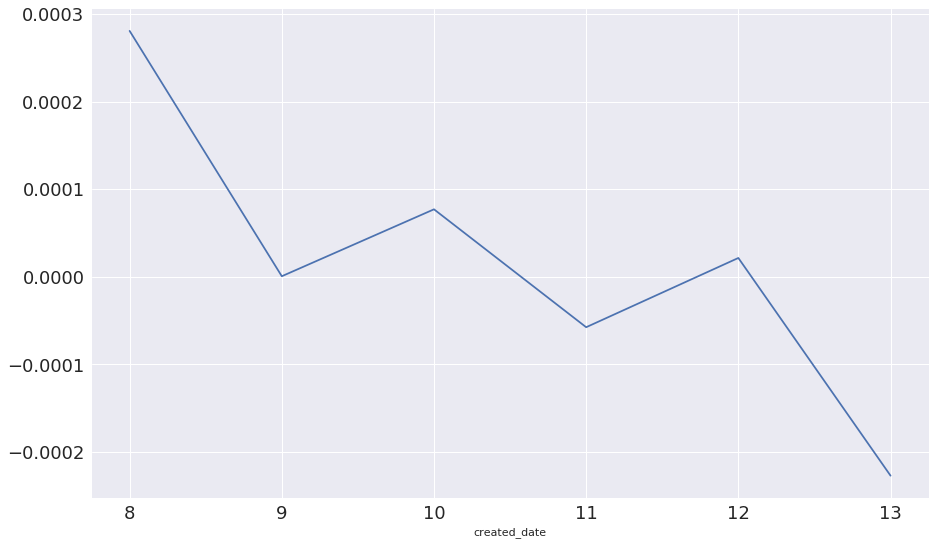

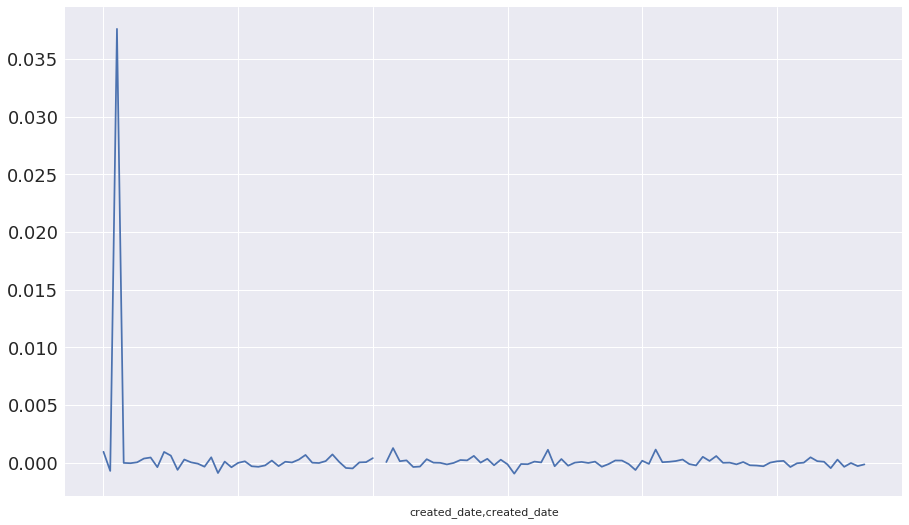

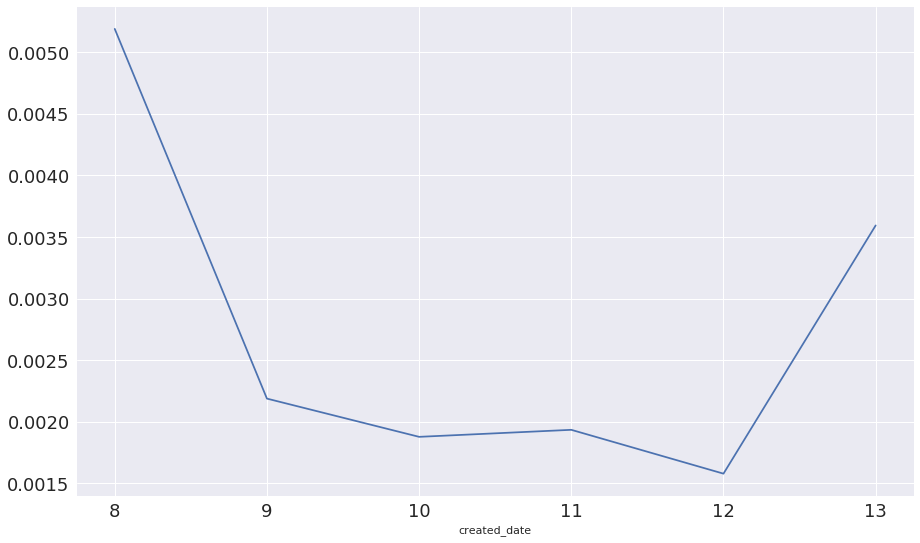

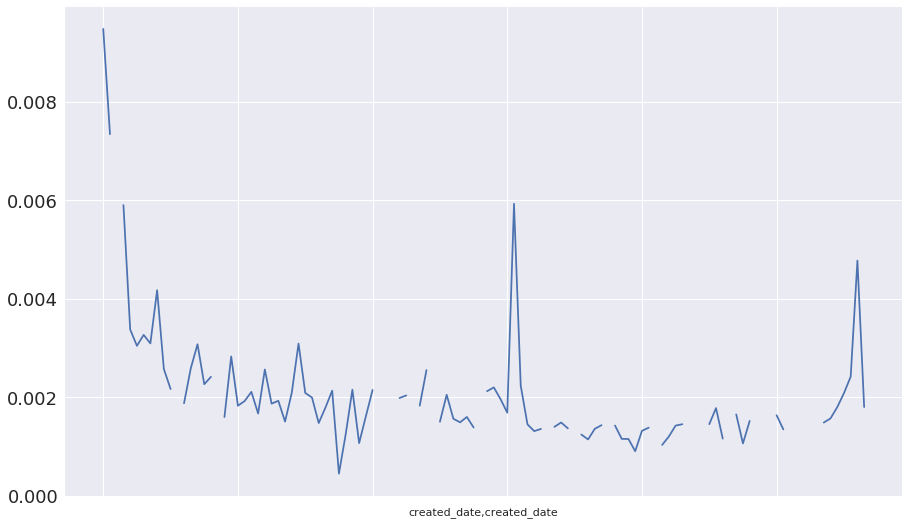

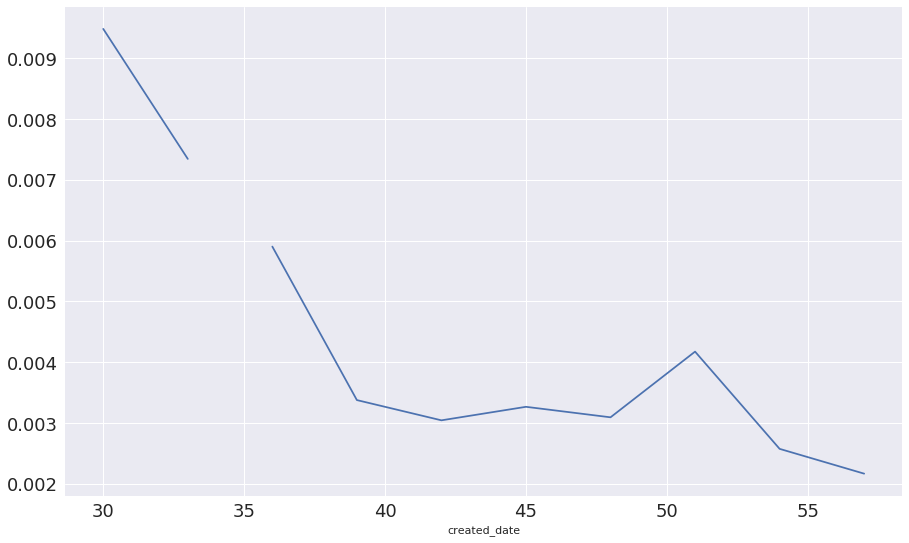

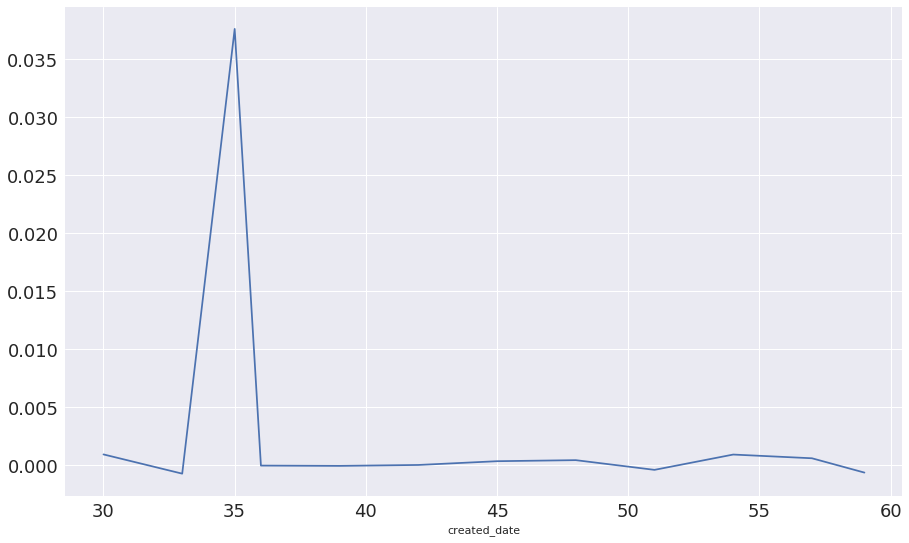

In [399]:
tr = (apr19.index.date >= datetime.date(2019,3,19)) & \
     (apr19.index.date <= datetime.date(2019,3,20))
apr19[tr].price.plot()
apr19[tr].log_ret.plot(secondary_y = True)
plt.figure()
apr19.groupby(apr19.index.hour).log_ret.mean().plot()
plt.figure()
apr19.groupby([apr19.index.hour,apr19.index.minute]).log_ret.mean().plot()
plt.figure()
apr19.groupby(apr19.index.hour).log_ret.std().plot()
plt.figure()
apr19.groupby([apr19.index.hour,apr19.index.minute]).log_ret.std().plot()
filter = (apr19.index.hour == 8)
plt.figure()
apr19[filter].groupby(apr19[filter].index.minute).log_ret.std().plot()
plt.figure()
apr19[filter].groupby(apr19[filter].index.minute).log_ret.mean().plot()

In [38]:
## crossing out till 8:30 - 8:40
filt = (apr19.index.time < datetime.time(8,30)) | (apr19.index.time > datetime.time(8,33))

/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


<Figure size 1080x648 with 0 Axes>

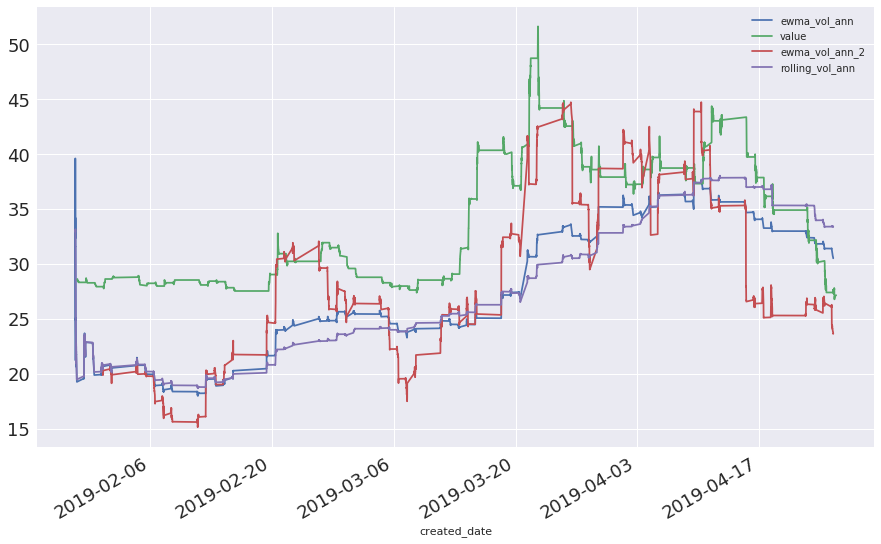

<Figure size 1080x648 with 0 Axes>

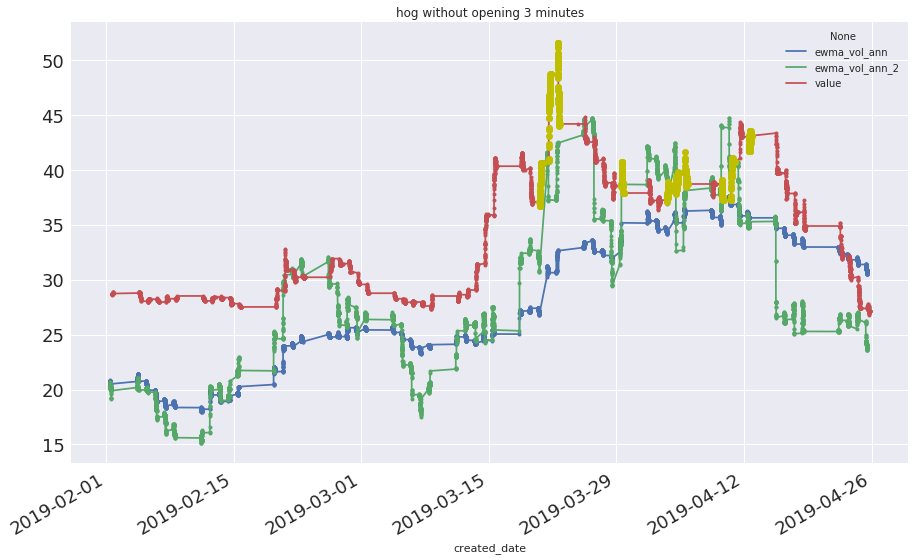

In [144]:
from functools import partial
## we are only looking into apr19 

## Going to use pd.DataFrame.ewma for optimization iteration

a = (np.sqrt(apr19[filt]['log_ret_sqr'].ewm(alpha = 0.001).mean()) * np.sqrt(252 * 4.2 * 20) * 100 )
apr19['ewma_vol_ann'] = None
apr19.loc[filt,'ewma_vol_ann'] = a
apr19[filt]['ewma_vol_ann'].plot()
apr19_vol.value.plot()

window = dates_rows_count(apr19,5)
alpha = 0.001    # This is ewma's decay factor. Which I really don't understand
weights = list(reversed([(1-alpha)**n for n in range(window)]))
ewma = partial(average, weights=weights)
rolling_average = np.sqrt(apr19[filt]['log_ret_sqr'].rolling(window).apply(ewma))* np.sqrt(252 * 4.2 * 20) * 100
apr19['ewma_vol_ann_2'] = None
apr19.loc[filt,'ewma_vol_ann_2'] = rolling_average
apr19[filt]['ewma_vol_ann_2'].plot()


rolling_no_weight = (apr19[filt].log_ret.rolling(dates_rows_count(apr19[filt],30), min_periods = 10).std()* np.sqrt(252 * 4.2 * 20)*100)
apr19['rolling_vol_ann'] = None
apr19.loc[filt,'rolling_vol_ann'] = rolling_no_weight
apr19[filt]['rolling_vol_ann'].plot()
plt.legend()
plt.figure()
apr19[(apr19.index.date >= datetime.date(2019,2,1)) & filt][['ewma_vol_ann','ewma_vol_ann_2']].plot(style = 'o-',ms = 4)
apr19_vol[apr19_vol.index.date>= datetime.date(2019,2,1)].value.plot(title = 'hog without opening 3 minutes',style = 'o-',ms = 4)
plt.legend()
for date in outlier_date:
    apr19_vol[apr19_vol.index.date == date].value.plot(style = 'o',c = 'y')


## Question: Infrequency of param dataset

In [43]:
# checking the time distribution of the implied vol
((apr19_vol.groupby(apr19_vol.index.hour).value.count()/len(apr19_vol))*100).round(2)
((apr19.groupby(apr19.index.hour).price.count()/len(apr19))*100).round(2)
## question --> only look into market hour and adj timezone

created_date
0      0.10
12     0.26
13    10.94
14    21.45
15    19.86
16    18.89
17    16.56
18     8.18
19     2.23
20     0.74
21     0.33
22     0.26
23     0.21
Name: value, dtype: float64

created_date
8     10.94
9     21.93
10    21.86
11    21.63
12    21.52
13     2.11
Name: price, dtype: float64

APR 10 2019 Notes
How to optimize the viewing option for dates:
    - want to pick out weekends
    - want to disregard null values

Thoughts on the graph: 
    - My calculation's daily change of vol has bigger distributino than that of implied vol (i.e 3-4)
        - this might come from the difference in how implied vol data is collected/saved
    - Big gap comes from 2-22, 3-06, 4-1 --> look into it

Outlier: 
    - flag 3/ 4.5  abs change to track outlier
    - see how implied is reading it --> there are only 3-06 and 3-18 range where implied > realized
    


## Outlier 

<Figure size 1080x648 with 0 Axes>

created_date
2019-01-28 08:30:01    0.0
2019-01-28 08:33:00    NaN
2019-01-28 08:36:03    NaN
2019-01-28 08:39:00    NaN
2019-01-28 08:42:02    NaN
Name: price, dtype: float64

<Figure size 1080x648 with 0 Axes>

<Figure size 1080x648 with 0 Axes>

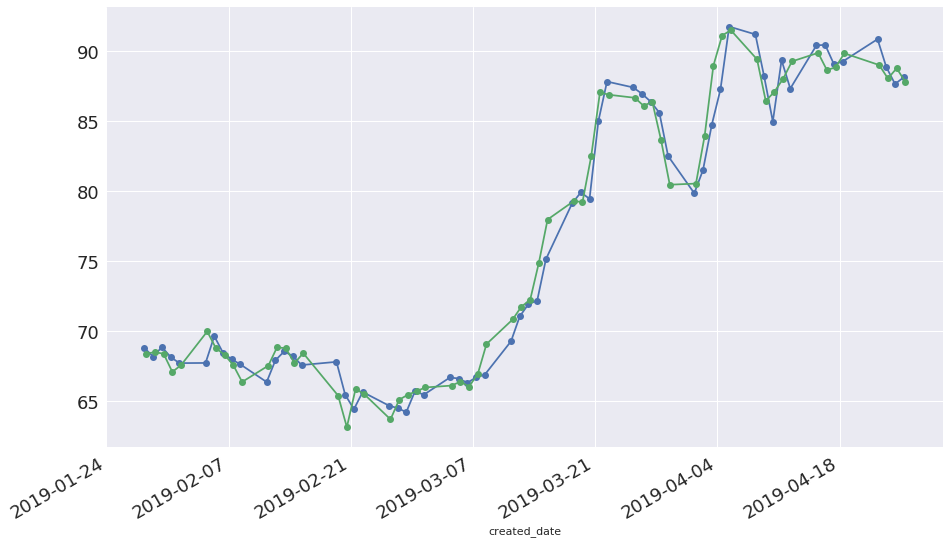

<Figure size 1080x648 with 0 Axes>

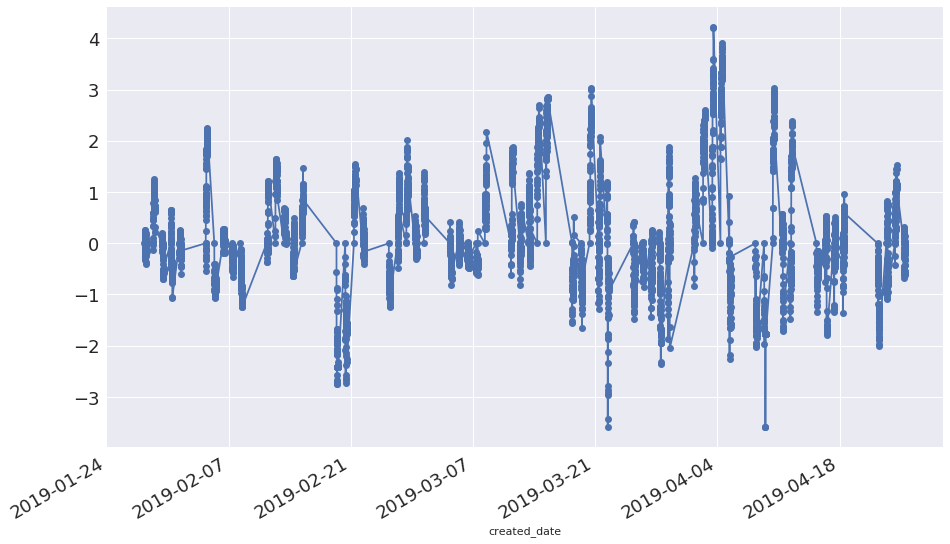

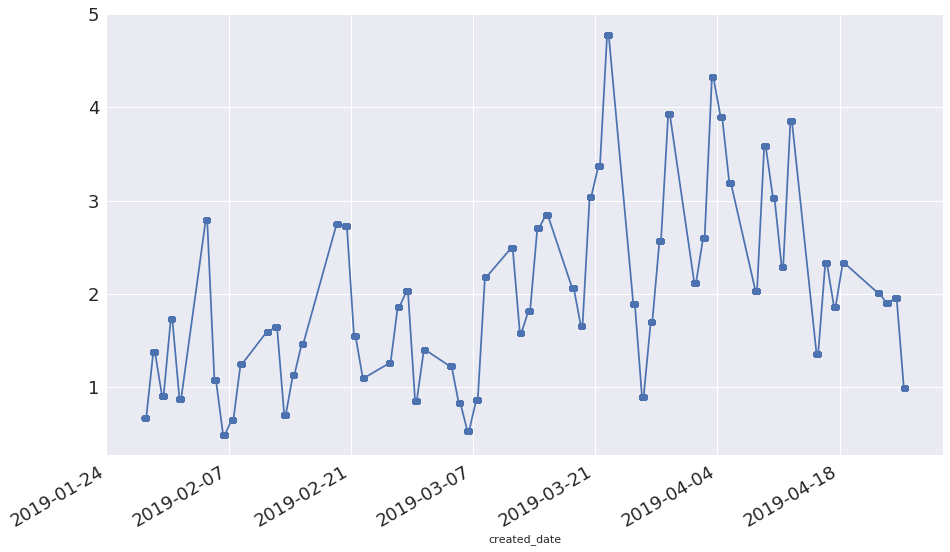

In [115]:
## flaging
#apr19.groupby(apr19.index.floor('D')).tail(n=1).price.plot(style = 'o-')
#apr19.groupby(apr19.index.ceil('D')).tail(n=1).price.plot(style = 'o-')
begin = apr19.groupby(apr19.index.floor('D')).head(n=1).price
end = apr19.groupby(apr19.index.floor('D')).tail(n=1).price
begin.plot(style = 'o-')
end.plot(style= 'o-')
plt.figure()
#apr19.groupby(apr19.index.floor('3H')).head(n=1).price.diff(periods = 1).max()

(apr19.price - begin).head()
apr19['delta'] = None
apr19['delta_min_max'] = None
for date in begin.index.date:
    filter = (apr19.index.date == date)
    apr19.loc[filter,'delta'] = apr19[filter].price - begin[begin.index.date == date].values
    apr19.loc[filter,'delta_min_max'] = apr19[filter].price.max() - apr19[filter].price.min()  
plt.figure()
apr19.delta.plot(style = 'o-')
plt.figure()
apr19.delta_min_max.plot(style = 'o-')

## calculate based on yesterday's low

<Figure size 1080x648 with 0 Axes>

<Figure size 1080x648 with 0 Axes>

<Figure size 1080x648 with 0 Axes>

<Figure size 1080x648 with 0 Axes>

<Figure size 1080x648 with 0 Axes>

<Figure size 1080x648 with 0 Axes>

<Figure size 1080x648 with 0 Axes>

<Figure size 1080x648 with 0 Axes>

<Figure size 1080x648 with 0 Axes>

<Figure size 1080x648 with 0 Axes>

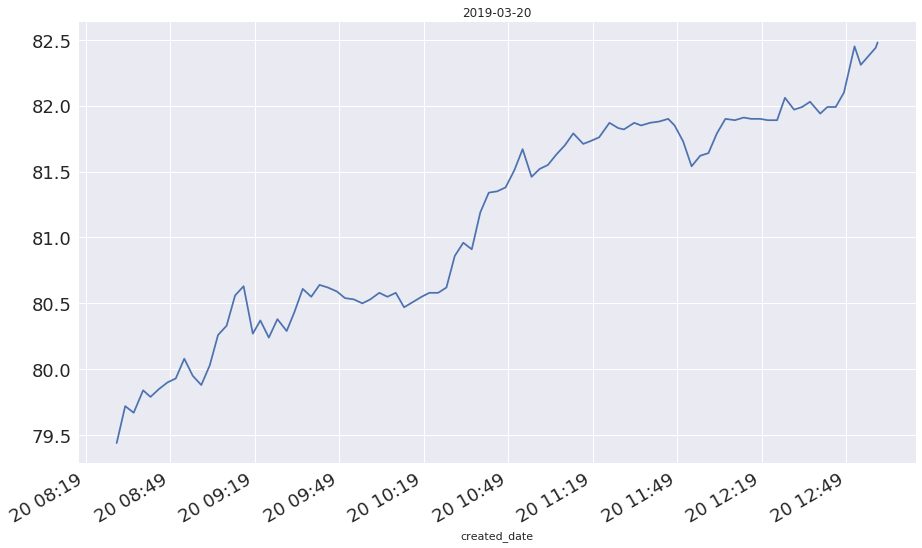

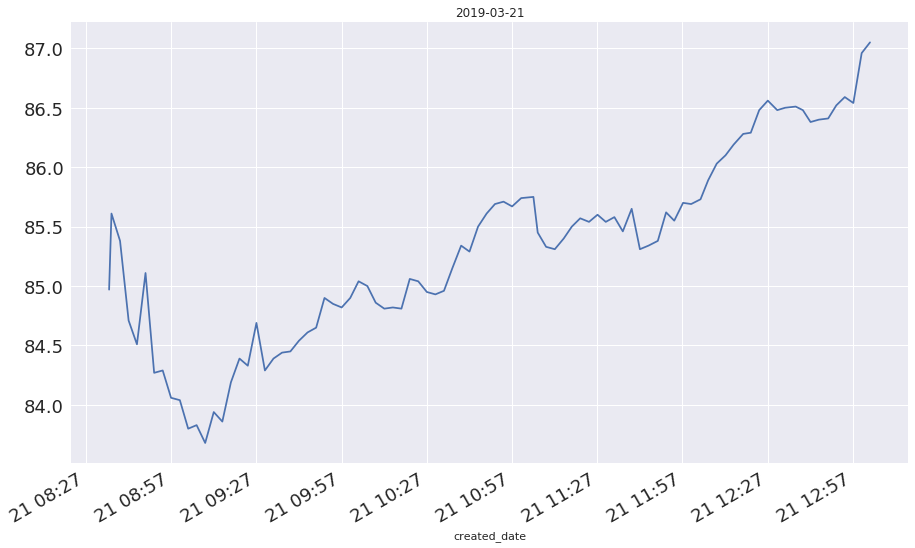

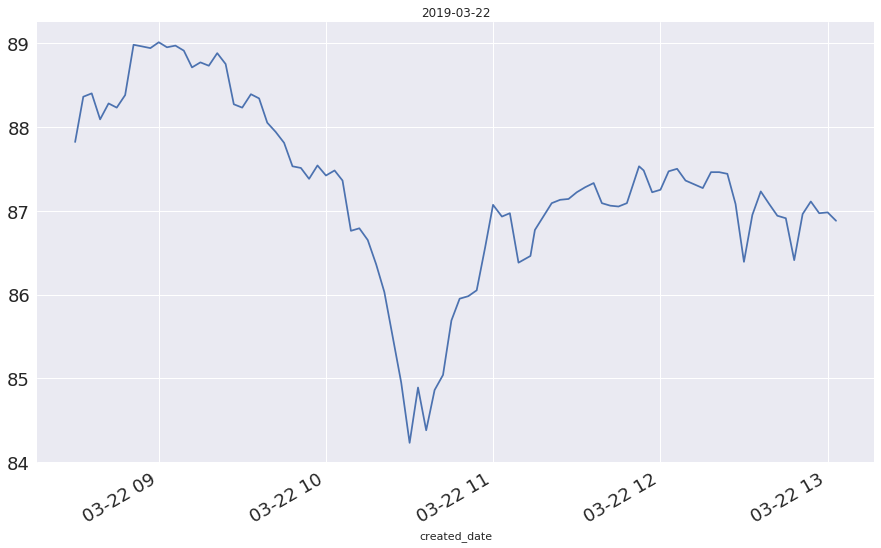

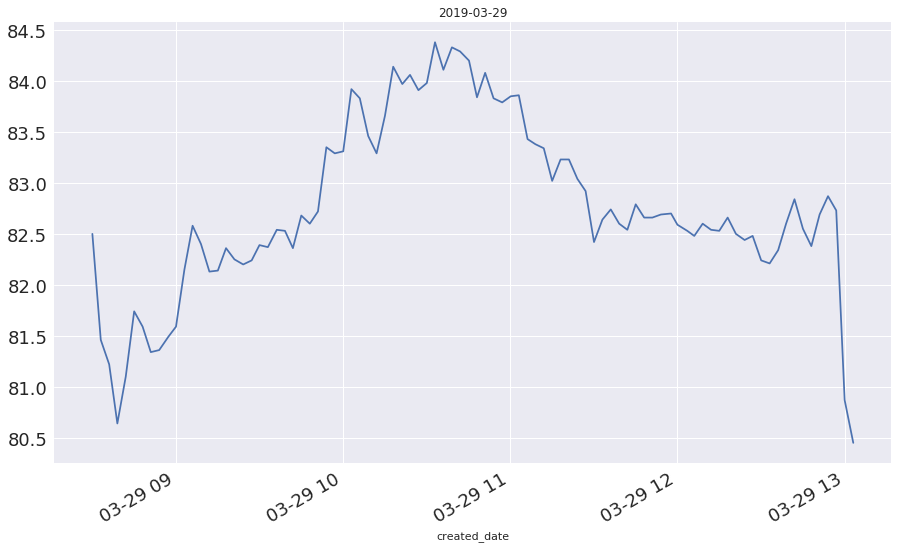

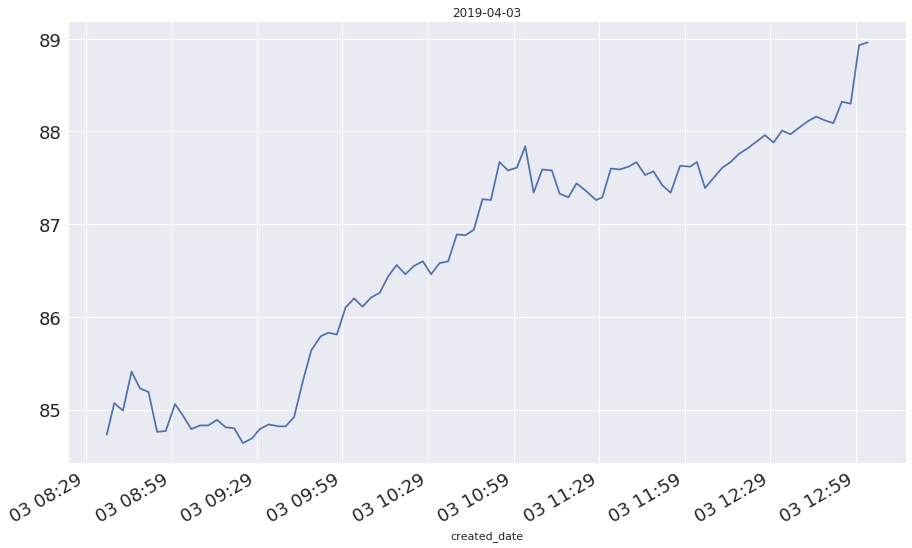

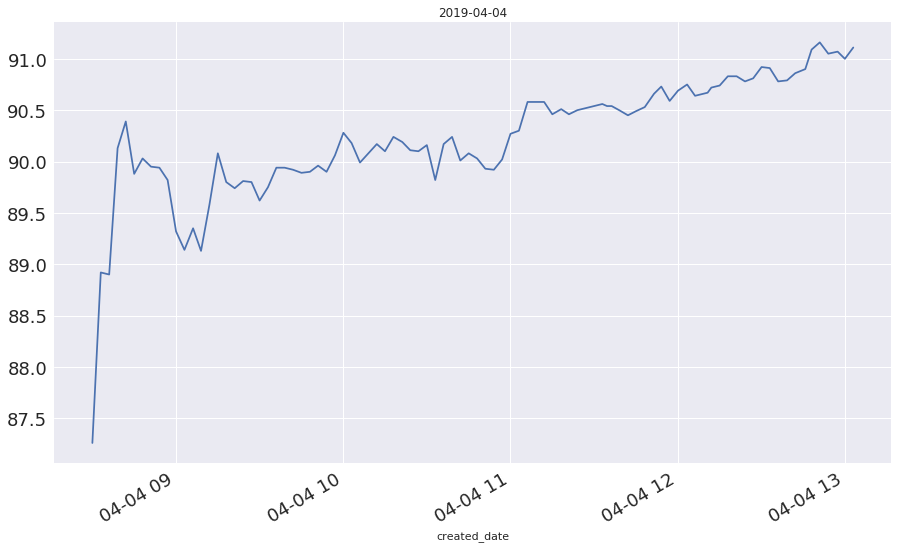

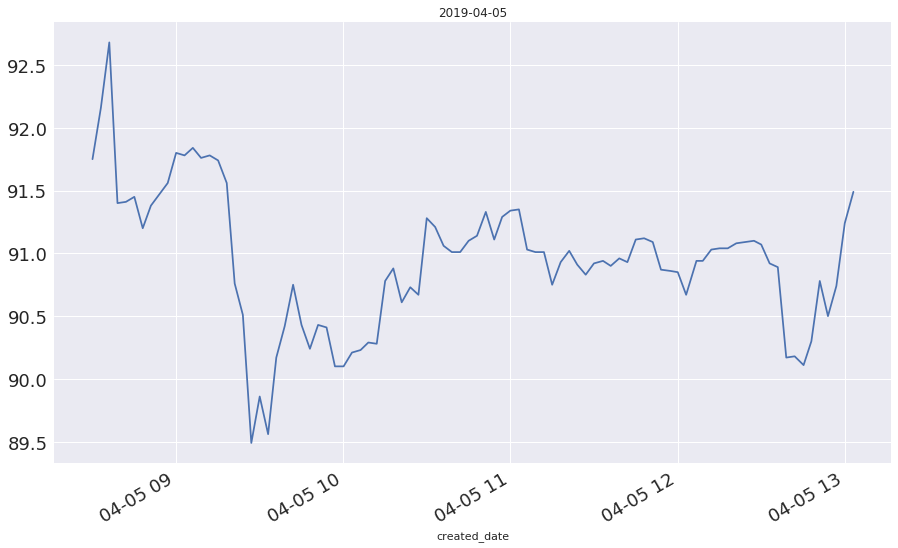

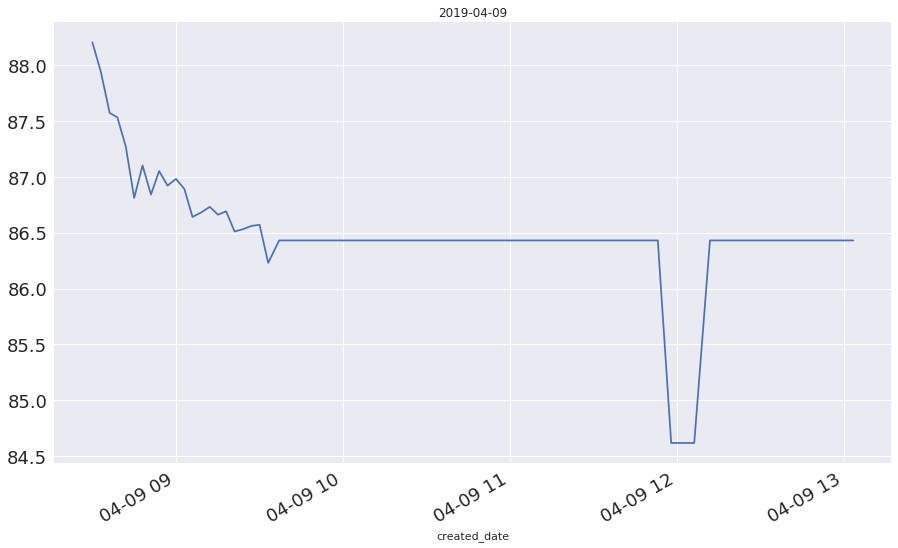

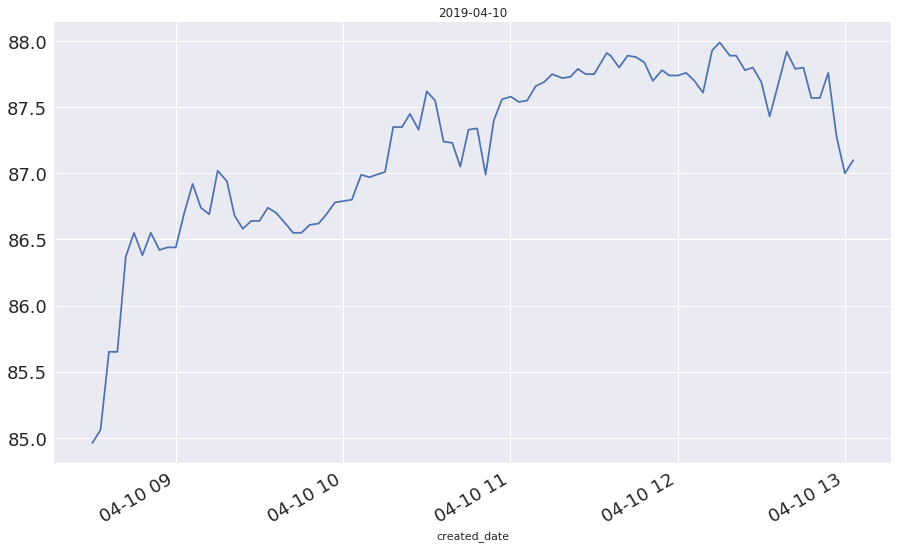

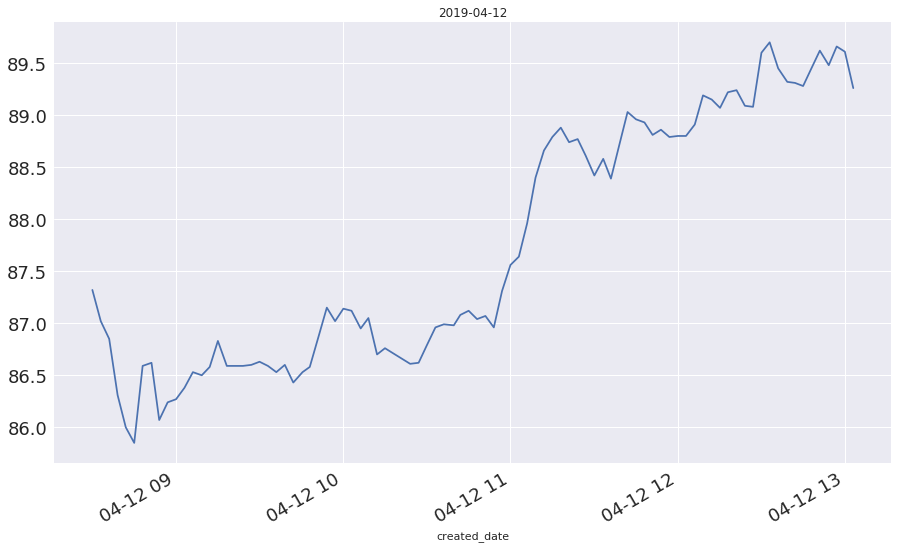

In [127]:
filter = apr19.delta_min_max >= 3
outlier_date = apr19[filter].groupby(apr19[filter].index.floor('D')).head(n=1).index.date
for date in outlier_date:
    plt.figure()
    apr19[apr19.index.date == date].price.plot(title = date)

In [110]:
## Outlier calculated by difference between open and intra day price of the same day
apr19[abs(apr19.delta) >= 3]

,index,id,product,expiry,price,log_ret,log_ret_sqr,ewma_vol_ann,ewma_vol_ann_2,rolling_vol_ann,delta,delta_min_max
created_date,,,,,,,,,,,,
2019-03-20 12:51:51,2262,4155884,HE,MAY19,82.45,0.004254,1.809679e-05,28.0327,25.2019,26.9233,3.01,3.04
2019-03-20 12:59:22,2260,4157201,HE,MAY19,82.44,0.001578,2.490554e-06,27.9942,25.0849,26.5859,3,3.04
2019-03-20 13:00:02,2259,4157375,HE,MAY19,82.48,0.000485,2.353062e-07,27.9286,24.9999,26.505,3.04,3.04
2019-03-22 10:30:04,2127,4243543,HE,MAY19,84.23,-0.008512,7.244897e-05,39.9476,42.7621,29.3131,-3.59,4.78
2019-03-22 10:36:01,2125,4244947,HE,MAY19,84.38,-0.006026,3.631140e-05,41.018,44.1633,29.4961,-3.44,4.78
2019-04-03 11:03:04,1385,4732943,HE,MAY19,87.84,0.002622,6.873998e-06,35.2131,34.0074,33.8715,3.11,4.32
2019-04-03 12:18:01,1360,4746938,HE,MAY19,87.76,0.001026,1.052779e-06,34.5215,33.4851,33.9732,3.03,4.32
2019-04-03 12:21:05,1359,4747450,HE,MAY19,87.82,0.000683,4.671028e-07,34.4423,33.3835,33.973,3.09,4.32
2019-04-03 12:24:04,1358,4747922,HE,MAY19,87.89,0.000797,6.348384e-07,34.3658,33.2968,33.9731,3.16,4.32


intermission:
 - why does inverse alpha makes a lot more sense? track the math
 - Track the difference in math between ewm function and rolling function
 - specify the outlier rule in hogs market
 - what's the exact hour for hog future? 

# Cattle

In [329]:
df = pd.read_sql_query(
           '''select *
           from future
            where product='LE' 
            and TIME(created_date) > '08:30:00' 
            and TIME(created_date) < '13:05:00'  
            and created_date > DATE_SUB(NOW(), INTERVAL 2 MONTH) 
            order by created_date desc''',
           con=engine)

param = pd.read_sql_query('''SELECT * 
    FROM staging.param 
    where product = 'XCME.LE' 
    and field = 'PE25'   
    and created_date > DATE_SUB(NOW(), INTERVAL 2 MONTH) 
    order by created_date desc ''',con=engine)

In [330]:
df.expiry.unique()

param.expiry.unique()


array([u'JUN19', u'AUG19', u'DEC19', u'APR20', u'OCT19', u'FEB20',
       u'APR19'], dtype=object)

array([u'MAY19', u'JUN19', u'AUG19', u'OCT19', u'DEC19', u'FEB20',
       u'APR19', u'MAR19'], dtype=object)

In [332]:
sampling_period = '3T' # from michael's script
# for ewma I'm going to use the half life function I made 
print df.expiry.unique()



df.created_date = pd.to_datetime(df.created_date)

#jul19 , apr19, jun19, may19, aug19, dec19, oct19, feb20 = [pd.DataFrame() for i in range(len(df.expiry.unique()))]
expiries = []
total_timerange = 5 # I will Try 5


for i in range(len(df.expiry.unique())):
    exp = pd.DataFrame()
    exp_str = df.expiry.unique()[i]
    exp = df[df.expiry == exp_str].groupby(df[df.expiry == exp_str ].created_date.dt.floor(sampling_period)).tail(n=1)
    exp = exp.reset_index()
    exp['index'] = exp.index
    exp = exp.set_index('created_date')
    exp = exp.sort_index()
    exp['log_ret'] = np.log(exp.price) - np.log(exp.price.shift(1))
    exp['log_ret_sqr'] = np.power(exp['log_ret'],2)
    
    print 'total time range of the data frame is : {}'.format(exp.index.max()-exp.index.min())
    ## gotta fix the date row count function slightly and update! 
    #exp = exp.sort_index(ascending = False) # because the most recent has to be on the first row for ewma calculation
    ## I'm going to just use the length of the df for ewma application. This has to updated later
    #as the ewma should be optimized
    #ewma_lambda = half_weight_lambda(dates_rows_count(exp, 5)) ## Here index means the iteration number. Don't be confused
    print "At this level, ewma lambda will be calculated as the 5 days"
    #exp['weight'] = (1-ewma_lambda)*np.power(ewma_lambda,exp['index'])
    #exp['weighted_log_ret_sqr'] = exp['weight'] * exp['log_ret_sqr']
    
    expiries.append(exp)
    
jun19c, aug19c ,dec19c, apr20c, oct19c, feb20c, apr19c = expiries



[u'JUN19' u'AUG19' u'DEC19' u'APR20' u'OCT19' u'FEB20' u'APR19']
total time range of the data frame is : 57 days 00:09:02
At this level, ewma lambda will be calculated as the 5 days
total time range of the data frame is : 57 days 00:09:02
At this level, ewma lambda will be calculated as the 5 days
total time range of the data frame is : 57 days 00:09:02
At this level, ewma lambda will be calculated as the 5 days
total time range of the data frame is : 8 days 00:09:01
At this level, ewma lambda will be calculated as the 5 days
total time range of the data frame is : 57 days 00:09:02
At this level, ewma lambda will be calculated as the 5 days
total time range of the data frame is : 57 days 00:09:02
At this level, ewma lambda will be calculated as the 5 days
total time range of the data frame is : 56 days 04:33:08
At this level, ewma lambda will be calculated as the 5 days


In [347]:
apr19c.head(10000)

,index,id,product,expiry,price,log_ret,log_ret_sqr,ewma_vol_ann,rolling_vol_ann,rolling_nw
created_date,,,,,,,,,,
2019-02-11 08:30:01,3678,1733282,LE,APR19,127.845,NaN,NaN,None,None,NaN
2019-02-11 08:33:00,3677,1735804,LE,APR19,128.204,0.002804,7.863272e-06,None,None,NaN
2019-02-11 08:36:00,3676,1737804,LE,APR19,128.163,-0.000320,1.023066e-07,None,None,NaN
2019-02-11 08:39:01,3675,1739524,LE,APR19,128.190,0.000211,4.437217e-08,None,None,NaN
2019-02-11 08:42:00,3674,1741102,LE,APR19,128.038,-0.001186,1.407648e-06,17.2618,NaN,NaN
2019-02-11 08:45:00,3673,1742730,LE,APR19,128.092,0.000422,1.777979e-07,12.9413,NaN,NaN
2019-02-11 08:48:05,3672,1744047,LE,APR19,128.011,-0.000633,4.001296e-07,11.8214,NaN,NaN
2019-02-11 08:51:00,3671,1745221,LE,APR19,127.982,-0.000227,5.133337e-08,10.3578,NaN,NaN
2019-02-11 08:54:00,3670,1746650,LE,APR19,127.788,-0.001517,2.301253e-06,13.5653,NaN,NaN


In [334]:



param.created_date = pd.to_datetime(param.created_date)

 
expiries = []

for i in range(len(param.expiry.unique())):
    exp = pd.DataFrame()
    exp_str = param.expiry.unique()[i]
    exp = param[param.expiry == exp_str].groupby(param[param.expiry == exp_str ].created_date.dt.floor(sampling_period)).tail(n=1)
    exp = exp.reset_index()
    exp['index'] = exp.index
    exp = exp.set_index('created_date')
    exp = exp.sort_index()
    expiries.append(exp)

may19_volc , jun19_volc, aug19_volc, oct19_volc, dec19_volc, feb20_volc, apr19_volc, mar19_volc = expiries

In [335]:
filt = (apr19c.index.time < datetime.time(8,30)) | (apr19c.index.time > datetime.time(8,40))

/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


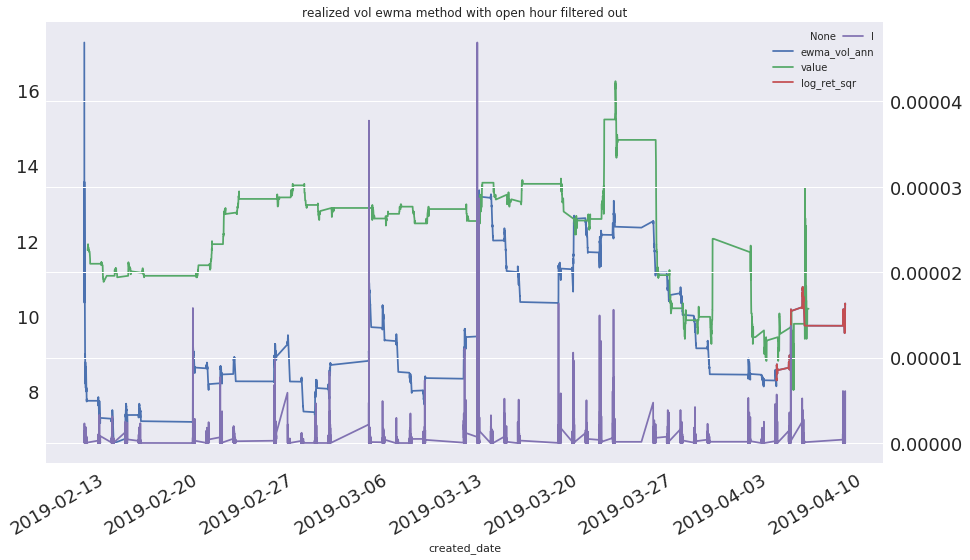

In [338]:
from functools import partial
## we are only looking into apr19 

## Going to use pd.DataFrame.ewma for optimization iteration

a = (np.sqrt(apr19c[filt]['log_ret_sqr'].ewm(alpha =0.005).mean()) * np.sqrt(252 * 4.2 * 20) * 100 )
apr19c['ewma_vol_ann'] = None
apr19c.loc[filt,'ewma_vol_ann'] = a
apr19c[filt]['ewma_vol_ann'].plot()
apr19_volc.value.plot(title = 'realized vol ewma method with open hour filtered out')

window = dates_rows_count(apr19c,7)
alpha = 0.005    # This is ewma's decay factor. Which I really don't understand
weights = list(reversed([(1-alpha)**n for n in range(window)]))
#weights = list([(1-alpha)**n for n in range(window)])
ewma = partial(average, weights=weights)
rolling_average = np.sqrt(apr19c[filt]['log_ret_sqr'].rolling(window).apply(ewma))* np.sqrt(252 * 4.2 * 20) * 100

rolling_average.plot()
plt.legend()
apr19c[filt].log_ret_sqr.plot(secondary_y = True)
plt.legend('log return sqred with with open hour filtered out')
apr19c['rolling_vol_ann'] = None
apr19c.loc[filt,'rolling_vol_ann'] = rolling_average


In [327]:
apr19c.shape

(3679, 9)

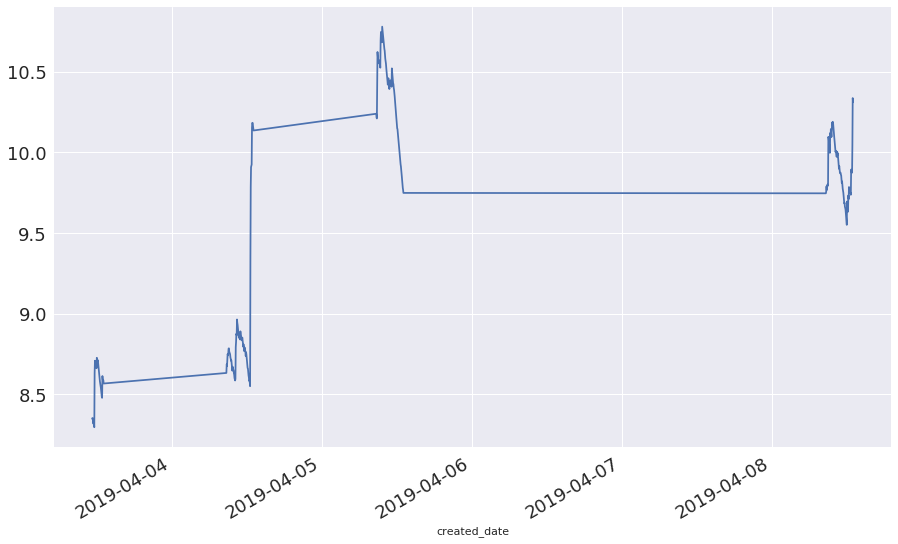

In [324]:
apr19c[filt].rolling_vol_ann.plot()

annualized volaitlity of the whole df time range


1.5132021083640568

rolling stuff


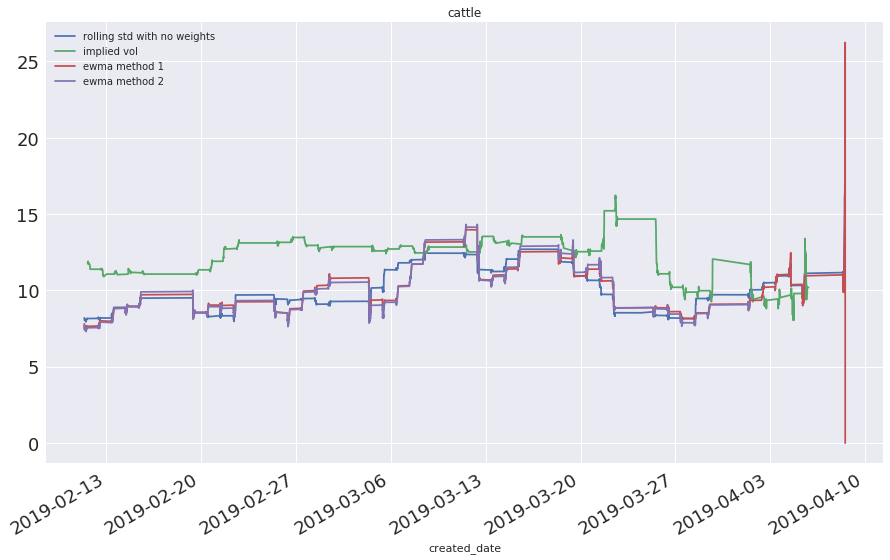

In [311]:
#apr19.head(-1)
## my understanding of ewma was the t = 0 return doesn't exist. <-- gotta check on the calculation. 
## This is the cause of the calculation mis match

## Also why is the tail of the rolling vol ann missin?
#apr19.ewma_vol_ann.plot()
print "annualized volaitlity of the whole df time range"
(np.sqrt(apr19c[filt].log_ret_sqr.sum()/len(apr19c[filt]))* np.sqrt(6 * 4.2 * 20)) * 100
print  "rolling stuff"
apr19c['rolling_nw'] = \
(apr19c[filt].log_ret.rolling(dates_rows_count(apr19,7), min_periods = 10).std()* np.sqrt(252 * 4.2 * 20)*100)
apr19c[filt].rolling_nw.plot()
apr19_volc.value.plot()
apr19c[filt].ewma_vol_ann.plot()
apr19c[filt].rolling_vol_ann.plot(title = 'cattle')
plt.legend(['rolling std with no weights','implied vol','ewma method 1','ewma method 2'])

In [314]:
# outlier over the weekend? 
# think how to use the first 10 min realized 
# capping the outlier to 2.5 std vs modifying the open 
# holding 2-3 days objectives
# 3-21 , 4-7 : 
# x trade, stddev, pnl , 

,index,id,product,expiry,price,log_ret,log_ret_sqr,weight,weighted_log_ret_sqr,ewma_vol_ann,rolling_vol_ann,rolling_nw
created_date,,,,,,,,,,,,
2019-04-08 13:03:09,0,4925964,LE,APR19,125.77,0.000000,0.000000e+00,0.002499,0.000000e+00,0,NaN,NaN
2019-04-08 13:00:03,1,4925165,LE,APR19,125.77,0.002468,6.090330e-06,0.002493,1.518296e-08,25.4208,NaN,NaN
2019-04-08 12:57:02,2,4924385,LE,APR19,125.46,-0.001911,3.652429e-06,0.002487,9.082611e-09,26.2438,NaN,NaN
2019-04-08 12:54:01,3,4923646,LE,APR19,125.70,0.000716,5.130096e-07,0.002481,1.272529e-09,23.294,NaN,NaN
2019-04-08 12:51:00,4,4922975,LE,APR19,125.61,0.000478,2.282767e-07,0.002474,5.648290e-10,21.0418,NaN,NaN


## my vol

# Functions

In [9]:
def half_weight_lambda(lag):
    try:
        type(lag) == int
    except: 
        return 'Variable Lag is not an Integer'
    
    polynom = [-1] + [0 for i in range(lag)] + [0.5]
    p = np.poly1d(polynom)
    print(np.poly1d(p))
    ewma_lambda = max([i for i in p.r.real])
    if ewma_lambda > 1:
        return 'error'
    else:
        return ewma_lambda

In [10]:
def dates_rows_count(df,days_num, offset = None):
    ###add filter on offset, minimum scale for calculation
    a = df.sort_index(ascending = False)
    return len(a.loc[: a.index.max() - pd.Timedelta(days = days_num)])

In [11]:
def ewma_realized_vol(df):
#    return np.sqrt(df['weighted_log_ret_sqr'].sum()) * np.sqrt(252 * 4.2 * 20)
    return np.sqrt(df['weighted_log_ret_sqr'].sum()/df['weight'].sum())* np.sqrt(252 * 4.2 * 20)

In [12]:
def bsm_price(option_type, sigma, s, k, r, T, q):
    # calculate the bsm price of European call and put options
    sigma = float(sigma)
    d1 = (np.log(s / k) + (r - q + sigma ** 2 * 0.5) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'c':
        price = np.exp(-r*T) * (s * np.exp((r - q)*T) * stats.norm.cdf(d1) - k *  stats.norm.cdf(d2))
        return price
    elif option_type == 'p':
        price = np.exp(-r*T) * (k * stats.norm.cdf(-d2) - s * np.exp((r - q)*T) *  stats.norm.cdf(-d1))
        return price
    else:
        print('No such option type %s') %option_type

In [13]:
def implied_vol(option_type, option_price, s, k, r, T, q):
    # apply bisection method to get the implied volatility by solving the BSM function
    precision = 0.00001
    upper_vol = 500.0
    max_vol = 500.0
    min_vol = 0.0001
    lower_vol = 0.0001
    iteration = 0

    while 1:
        iteration +=1
        mid_vol = (upper_vol + lower_vol)/2.0
        price = bsm_price(option_type, mid_vol, s, k, r, T, q)
        if option_type == 'c':

            lower_price = bsm_price(option_type, lower_vol, s, k, r, T, q)
            if (lower_price - option_price) * (price - option_price) > 0:
                lower_vol = mid_vol
            else:
                upper_vol = mid_vol
            if abs(price - option_price) < precision: 
                break 
            if mid_vol > max_vol - 5 :
                mid_vol = 0.000001
                break

        elif option_type == 'p':
            upper_price = bsm_price(option_type, upper_vol, s, k, r, T, q)

            if (upper_price - option_price) * (price - option_price) > 0:
                upper_vol = mid_vol
            else:
                lower_vol = mid_vol
            if abs(price - option_price) < precision: 
                break 
            if iteration > 50: 
                break

    return mid_vol